In [1]:
!pip install torchmetrics
!pip install torchinfo

  Obtaining dependency information for torchmetrics from https://files.pythonhosted.org/packages/9d/e1/84066ff60a20dfa63f4d9d8ddc280d5ed323b7f06504dbb51c523b690116/torchmetrics-1.6.1-py3-none-any.whl.metadata
  Obtaining dependency information for lightning-utilities>=0.8.0 from https://files.pythonhosted.org/packages/85/f3/1305321a12c984405e26fc64b5d521569e9872fb811f4aace8e168099160/lightning_utilities-0.11.9-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 9.7 MB/s eta 0:00:000m eta 0:00:010:01

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for torchinfo from https://files.pythonhosted.org/packages/72/25/973bd6128381951b23cdcd8a9870c6dcfc5606cb864df8eabd82e529f9c1/torchinfo-1.8.0-py3-none-any.whl.metadata

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


 Import libraries

In [2]:
# Standard python libraries
import collections
# Scientific python
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
# Great progress bar
import tqdm.auto as tqdm
# ML: PCA
import sklearn.decomposition
# Our DL stack
import torch
import torch.nn as nn
import torchvision
import torch.utils.data as torch_data
import torch.nn.functional as F

# DL utilities
import torchinfo
import torchmetrics

print(torch.__version__)
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print(f"Using device: {device}")

ImportError: dlopen(/Users/hanheelee/anaconda3/lib/python3.11/site-packages/torch/_C.cpython-311-darwin.so, 0x0002): Library not loaded: @loader_path/libtorch_cpu.dylib
  Referenced from: <93B052AD-B16C-3D0F-A6FC-DFFBB7CD9584> /Users/hanheelee/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_python.dylib
  Reason: tried: '/Users/hanheelee/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib' (no such file), '/usr/local/lib/libtorch_cpu.dylib' (no such file), '/usr/lib/libtorch_cpu.dylib' (no such file, not in dyld cache)

# Define hyperparameters


In [ ]:
BATCH_SIZE = 512
EPOCHS = 5
SEED = 42
LR=1e-3
LATENT_DIM = 2
NUM_LAYERS = 3
VAL_SIZE = 0.1
HIDDEN_DIM = 100

Some constants

In [ ]:
W = 28
H = 28
C = 1
IMG_SIZE = W*H

Set random seed

In [ ]:
torch.manual_seed(SEED)
np.random.seed(SEED)

Load datasets

In [ ]:
full_dataset = torchvision.datasets.FashionMNIST('./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.FashionMNIST('./data', train=False, download=True, transform=torchvision.transforms.ToTensor())
train_size = int((1-VAL_SIZE) * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch_data.random_split(full_dataset, [train_size, val_size])

Create dataloaders

In [ ]:
train_loader = torch_data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=cuda)
val_loader = torch_data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=cuda)
test_loader = torch_data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=cuda)

# Define a VAE

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=3):
        super(VAE, self).__init__()
        self.num_layers = num_layers
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        encoder_layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        for _ in range(num_layers - 1):
            encoder_layers.append(nn.Linear(hidden_dim, hidden_dim))
            encoder_layers.append(nn.ReLU())

        self.encoder_layers = nn.Sequential(*encoder_layers)
        self.encoder_mu = nn.Linear(hidden_dim, latent_dim)
        self.encoder_logvar = nn.Linear(hidden_dim, latent_dim)


        decoder_layers = [nn.Linear(latent_dim, hidden_dim), nn.ReLU()]
        for _ in range(num_layers - 1):
            decoder_layers.append(nn.Linear(hidden_dim, hidden_dim))
            decoder_layers.append(nn.ReLU())

        self.decoder_layers = nn.Sequential(*decoder_layers)
        self.decoder_output = nn.Linear(hidden_dim, input_dim)


    def encode(self, x):
        h = self.encoder_layers(x)
        return self.encoder_mu(h), self.encoder_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_layers(z)
        return torch.sigmoid(self.decoder_output(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, IMG_SIZE))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

Create the model

In [ ]:
model = VAE(input_dim=IMG_SIZE, hidden_dim=HIDDEN_DIM,
            latent_dim=LATENT_DIM, num_layers=NUM_LAYERS).to(device)
print("Model Summary:")
torchinfo.summary(model, input_size=(BATCH_SIZE, IMG_SIZE))

Model Summary:


Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [512, 784]                --
├─Sequential: 1-1                        [512, 100]                --
│    └─Linear: 2-1                       [512, 100]                78,500
│    └─ReLU: 2-2                         [512, 100]                --
│    └─Linear: 2-3                       [512, 100]                10,100
│    └─ReLU: 2-4                         [512, 100]                --
│    └─Linear: 2-5                       [512, 100]                10,100
│    └─ReLU: 2-6                         [512, 100]                --
├─Linear: 1-2                            [512, 2]                  202
├─Linear: 1-3                            [512, 2]                  202
├─Sequential: 1-4                        [512, 100]                --
│    └─Linear: 2-7                       [512, 100]                300
│    └─ReLU: 2-8                         [512, 100]                --


Our loss function

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, IMG_SIZE), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

Our optimizer

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training loop

In [ ]:
def train(epoch):
    model.train()
    train_loss = 0
    progress_bar = tqdm.tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Train Epoch {epoch}")
    for batch_idx, (data, _) in progress_bar:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
          progress_bar.set_postfix({'loss':loss.item() / len(data)})
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [ ]:
def evaluate(model, dataloader, epoch, device):
    model.eval()
    val_loss = 0
    ssim = torchmetrics.StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    with torch.no_grad():
      progress_bar = tqdm.tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Validation Epoch {epoch}")
      for i, (data, _) in progress_bar:
          data = data.to(device)
          recon_batch, mu, logvar = model(data)
          val_loss += loss_function(recon_batch, data, mu, logvar).item()
          ssim(recon_batch.view(-1, C, W, H), data.view(-1, C, W, H))
    val_loss /= len(dataloader.dataset)
    ssim_score = ssim.compute()
    print('====> Validation set loss: {:.4f}'.format(val_loss))
    print(f'====> Validation set SSIM: {ssim_score:.4f}')

In [ ]:
def visualize_comparison(model, dataloader, epoch, device):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(dataloader))
        data = data.to(device)
        recon_batch, mu, logvar = model(data)

    n = min(data.size(0), 8)
    comparison = torch.cat([data[:n],
                                recon_batch.view(BATCH_SIZE, C, W, H)[:n]])
    fig, axes = plt.subplots(2, n, figsize=(10, 3))
    for j in range(n):
        axes[0, j].imshow(data[j].cpu().squeeze().numpy(), cmap='gray', vmin=0, vmax=1.0)
        axes[0, j].axis('off')
        axes[1, j].imshow(recon_batch.view(BATCH_SIZE, C, W, H)[j].cpu().squeeze().numpy(), cmap='gray', vmin=0, vmax=1.0)
        axes[1, j].axis('off')
    plt.suptitle(f"Reconstructions at Epoch {epoch}")
    plt.show()


Train Epoch 1:   0%|          | 0/106 [00:00<?, ?it/s]

====> Epoch: 1 Average loss: 388.3369


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


Validation Epoch 1:   0%|          | 0/12 [00:00<?, ?it/s]

====> Validation set loss: 308.6773
====> Validation set SSIM: 0.3741


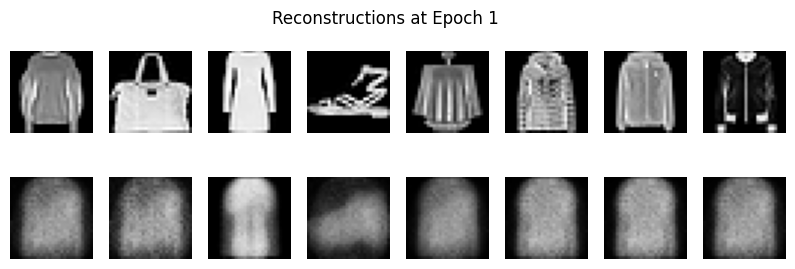

Train Epoch 2:   0%|          | 0/106 [00:00<?, ?it/s]

====> Epoch: 2 Average loss: 291.4469


Validation Epoch 2:   0%|          | 0/12 [00:00<?, ?it/s]

====> Validation set loss: 284.4228
====> Validation set SSIM: 0.4764


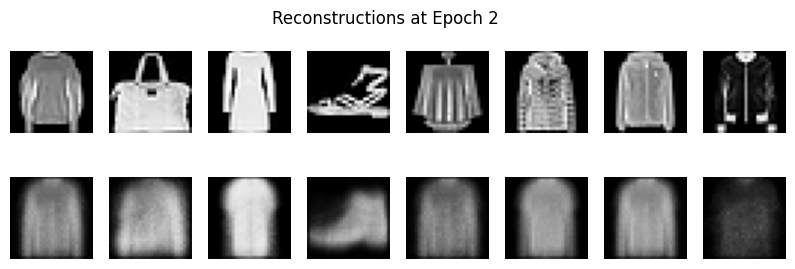

Train Epoch 3:   0%|          | 0/106 [00:00<?, ?it/s]

====> Epoch: 3 Average loss: 281.0829


Validation Epoch 3:   0%|          | 0/12 [00:00<?, ?it/s]

====> Validation set loss: 279.1922
====> Validation set SSIM: 0.5025


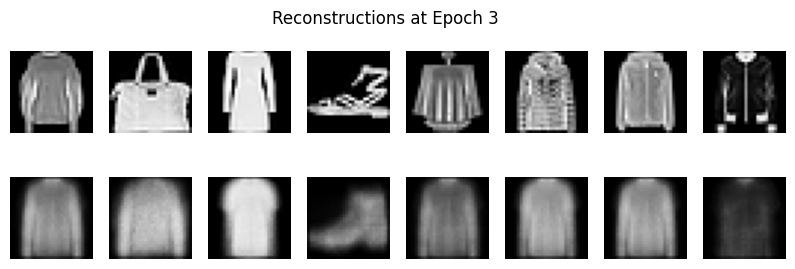

Train Epoch 4:   0%|          | 0/106 [00:00<?, ?it/s]

====> Epoch: 4 Average loss: 276.1931


Validation Epoch 4:   0%|          | 0/12 [00:00<?, ?it/s]

====> Validation set loss: 275.1314
====> Validation set SSIM: 0.5241


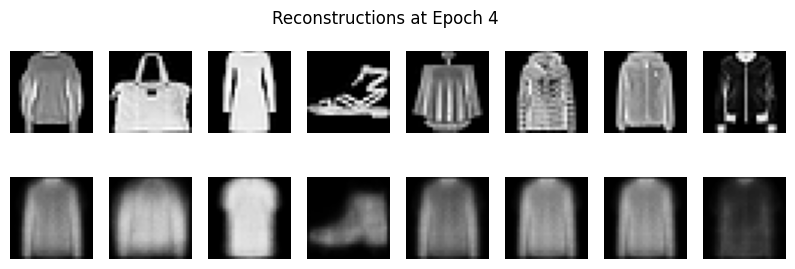

Train Epoch 5:   0%|          | 0/106 [00:00<?, ?it/s]

====> Epoch: 5 Average loss: 272.7632


Validation Epoch 5:   0%|          | 0/12 [00:00<?, ?it/s]

====> Validation set loss: 272.7960
====> Validation set SSIM: 0.5349


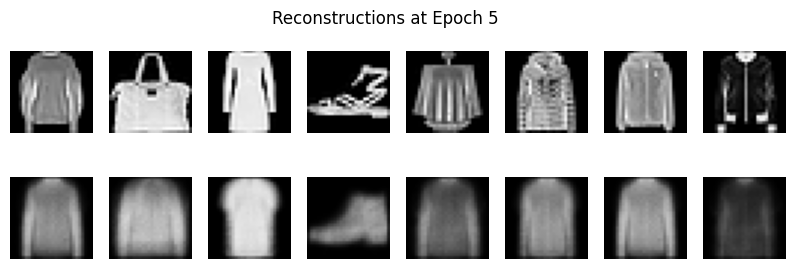

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    evaluate(model, val_loader, epoch, device)
    visualize_comparison(model, val_loader, epoch, device)

# Let's generate new data


In [ ]:
n = 8
random_z = torch.randn(n, LATENT_DIM).to(device)
model.eval()
with torch.no_grad():
    random_samples = model.decode(random_z).cpu().detach().numpy()
random_samples.shape

(8, 784)

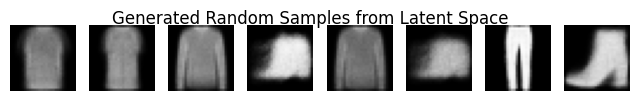

In [ ]:
ig, axes = plt.subplots(1, n, figsize=(n, 1))
for i, ax in enumerate(axes.flat):
    ax.imshow(random_samples[i].reshape(W, H), cmap='gray', vmin=0, vmax=1.0)
    ax.axis('off')
plt.suptitle("Generated Random Samples from Latent Space")
plt.show()

# Visualize 2D manifold

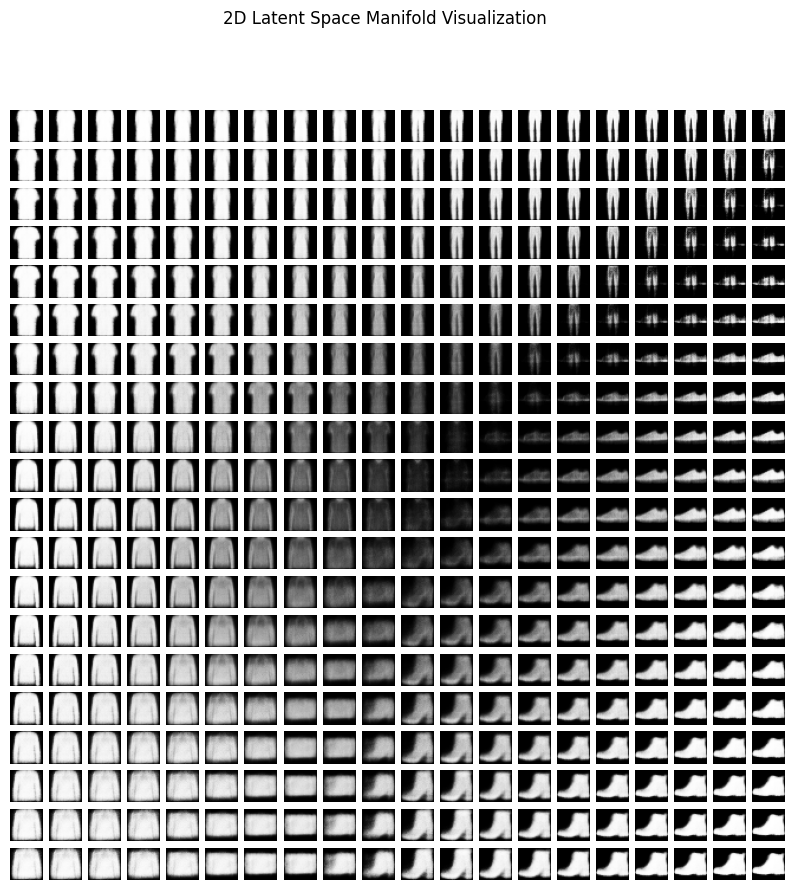

In [ ]:
n = 20
img_size = 28

x = np.linspace(-3, 3, n)
y = np.linspace(-3, 3, n)
xv, yv = np.meshgrid(x, y)

model.eval()
with torch.no_grad():
    latent_points = torch.tensor(np.stack([xv.flatten(), yv.flatten()], axis=1), dtype=torch.float).to(device)
    decoded_imgs = model.decode(latent_points).cpu().numpy().reshape(n, n, img_size, img_size)

fig, axes = plt.subplots(n, n, figsize=(10, 10))
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(decoded_imgs[i, j], cmap='gray', vmin=0, vmax=1.0)
        ax.axis('off')
plt.suptitle("2D Latent Space Manifold Visualization")
plt.show()

# Few shot learning
## Create a small few-shot learning dataset

In [ ]:
n_samples_per_class = 5

model.eval()
latent_train = []
labels_train = []
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        mu, _ = model.encode(images.view(images.size(0), -1))
        latent_train.append(mu.cpu().numpy())
        labels_train.append(labels.cpu().numpy())
latent_train = np.concatenate(latent_train, axis=0)
labels_train = np.concatenate(labels_train, axis=0)
unique_labels = np.unique(labels_train)
few_shot_indices = []
for label in unique_labels:
    class_indices = np.where(labels_train == label)[0]
    selected_indices = np.random.choice(class_indices, size=min(n_samples_per_class, len(class_indices)), replace=False)
    few_shot_indices.extend(selected_indices)
few_shot_latent_train = latent_train[few_shot_indices]
few_shot_labels_train = labels_train[few_shot_indices]

In [ ]:
latent_test = []
labels_test = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        mu, _ = model.encode(images.view(images.size(0), -1))
        latent_test.append(mu.cpu().numpy())
        labels_test.append(labels.cpu().numpy())
latent_test = np.concatenate(latent_test, axis=0)
labels_test = np.concatenate(labels_test, axis=0)
print(few_shot_latent_train.shape)

(50, 2)


Train a sklearn model (K-Nearest neighbors)

In [ ]:
pipeline = sklearn.pipeline.Pipeline([
    ('scaler', sklearn.preprocessing.StandardScaler()),
    ('knn', sklearn.neighbors.KNeighborsClassifier(n_neighbors=3))
    ])
pipeline.fit(few_shot_latent_train, few_shot_labels_train)
predictions = pipeline.predict(latent_test)
accuracy = sklearn.metrics.accuracy_score(labels_test, predictions)
print(f'Few-Shot Accuracy on Test Set: {accuracy:.4f}')

Few-Shot Accuracy on Test Set: 0.5482
